## Loading Libraries and Dependencies

In [1]:
#specify the packages of interest
options(warn=-1)
options(repr.plot.width=6, repr.plot.height=4)

packages = c("haven", "tidyverse", "plyr", "ggplot2", "dplyr", "maptools", "rgdal")

## Check to see if package is available and load else install the package and its dependencies
package.check <- lapply(packages, FUN = function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x, dependencies = TRUE)
    library(x, character.only = TRUE)
  }
})

Loading required package: haven
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: plyr
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The followi

ERROR: Error: package or namespace load failed for ‘rgdal’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Users/ibrahim/anaconda3/lib/R/library/rgdal/libs/rgdal.so':
  dlopen(/Users/ibrahim/anaconda3/lib/R/library/rgdal/libs/rgdal.so, 6): Library not loaded: @rpath/libfontconfig.1.dylib
  Referenced from: /Users/ibrahim/anaconda3/lib/libpoppler.78.dylib
  Reason: Incompatible library version: libpoppler.78.dylib requires version 14.0.0 or later, but libfontconfig.1.dylib provides version 13.0.0


## Data Preprocessing

In [2]:
##Read in data
childrenfinal <- read_dta("data/childrenfinal.dta")

## Remove specific columns with a regex expression
pattern <- "^[s,m,v]\\d"
cols <- grep(pattern, names(childrenfinal), value=T)
childrenfinal <- childrenfinal[ , !(names(childrenfinal) %in% cols)]

## Select data subset
col_subset = c("hypage","ruralfacto", "female", "zstunt", "zweight", "zwast", "adm2")
children_subset <- childrenfinal%>%select(col_subset)

## Changing dtype of columns
children_subset <- within(children_subset, 
                          {gender <- factor(female, labels = c("Male", "Female")) 
                          settlement <- factor(ruralfacto, labels = c("rural", "urban"))})


## Sample Data Visualizations

Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


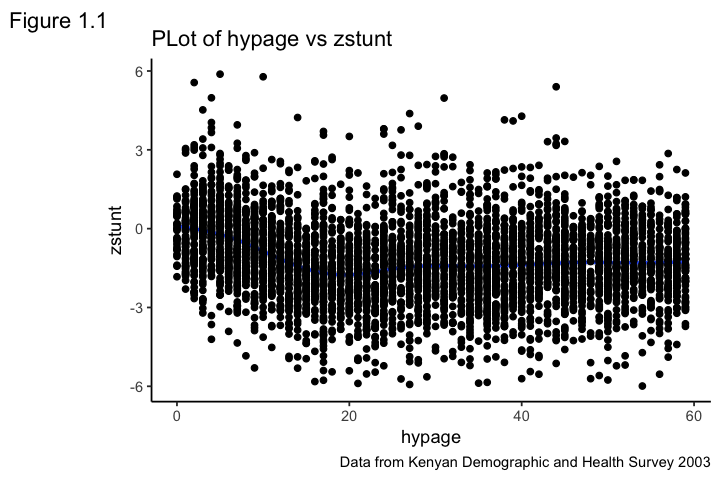

In [8]:
## Scatter plot of zstunt vs hypage with smoothing line
ggplot(children_subset, aes(x=hypage, y= zstunt)) + geom_smooth() + geom_point() + theme_classic() + 
  labs(title = "PLot of hypage vs zstunt",caption = "Data from Kenyan Demographic and Health Survey 2003",
       tag = "Figure 1.1",x = "hypage",y = "zstunt") + theme_classic()


Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.


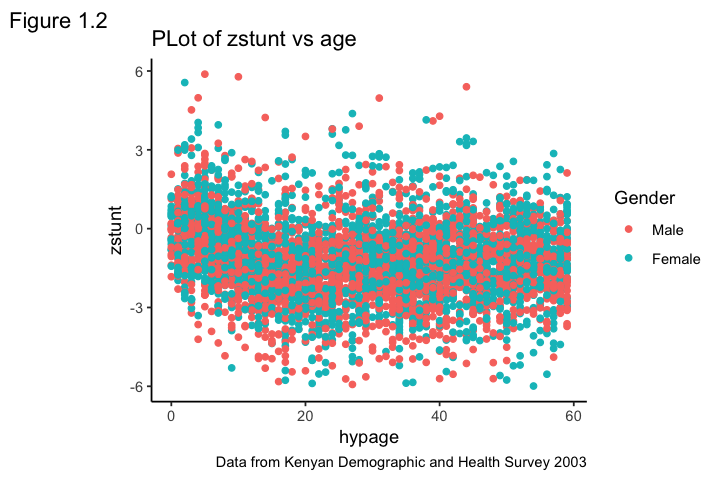

In [11]:
# Scatter plot of zstunt vs age 
ggplot(children_subset) + geom_point(aes(x=hypage, y= zstunt, colour=gender))  +
  labs(title = "PLot of zstunt vs age",caption = "Data from Kenyan Demographic and Health Survey 2003",
       tag = "Figure 1.2",x = "hypage",y = "zstunt", colour = "Gender") + theme_classic()

Don't know how to automatically pick scale for object of type labelled. Defaulting to continuous.


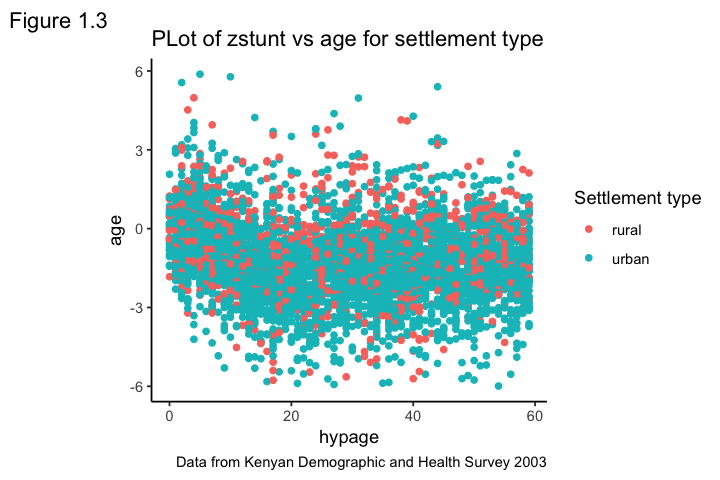

In [5]:
# Scatter plot of zstunt vs rural/urban 
ggplot(children_subset) + geom_point(aes(x=hypage, y= zstunt, colour=settlement)) + geom_smooth() +
  labs(title = "PLot of zstunt vs age for settlement type",caption = "Data from Kenyan Demographic and Health Survey 2003",
       tag = "Figure 1.3",x = "hypage",y = "age", colour = "Settlement type") + theme_classic()

## Spatial Analysis of Dataset

In [6]:
## Agregate data by region according to average zstunt
zstunt_data <- data.frame(region= c(children_subset$adm2), zstunt=c(children_subset$zstunt))
agg <- aggregate(zstunt_data, by=list(zstunt_data$region), FUN=mean)
agg$region <- NULL
colnames(agg)[colnames(agg)=="Group.1"] <- "NAME_1"
agg <- agg %>% add_row(NAME_1 = "ISOLO", zstunt = 0)

In [7]:
Kenya<-getData("GADM", country="KE", level=1)

## Set an appropriate projection for the data
Kenya_UTM<-spTransform(Kenya, CRS("+init=EPSG:32737"))  

Kenya_UTM@data$id <- rownames(Kenya_UTM@data)

## Add aggregate data to map data
Kenya_UTM@data <- join(Kenya_UTM@data, agg, by="NAME_1")
Kenya_df <- fortify(Kenya_UTM)
Kenya_df <- join(Kenya_df,Kenya_UTM@data, by="id")

ERROR: Error in getData("GADM", country = "KE", level = 1): could not find function "getData"


In [ ]:
## Generate dataset needed for adding labels to the geo-spatial map
centroids_df <- as.data.frame(coordinates(Kenya_UTM))
names(centroids_df) <- c("long", "lat")
agg<- agg[order(agg$NAME_1),]
centroids_df$NAME_1 <- Kenya_UTM@data$NAME_1
centroids_df$zstunt.mean <- agg$zstunt

In [ ]:
## Configure theme options for the map
theme_opts<-list(theme(panel.grid.minor = element_blank(),
                       panel.grid.major = element_blank(),
                       panel.background = element_blank(),
                       plot.background = element_blank(),
                       axis.line = element_blank(),
                       axis.text.x = element_blank(),
                       axis.text.y = element_blank(),
                       axis.ticks = element_blank(),
                       axis.title.x = element_blank(),
                       axis.title.y = element_blank(),
                       plot.title = element_blank()))

In [ ]:
## Visualize the zstunt data on the Kenyan map
ggplot() + geom_polygon(data = Kenya_df, 
                        aes(x = long, y = lat, group = group, fill =zstunt), 
                        color = "black", size = 0.25) + theme(aspect.ratio=1) +   
  geom_text (data=centroids_df, aes(x=long, y=lat, label=NAME_1), position = "identity", check_overlap = TRUE)
